**Data Proprocessing**


In [ ]:
%pip install chembl_webresource_client > nul 2>&1
%pip install pandas > nul 2>&1

In [ ]:
import pandas as pd
from chembl_webresource_client.new_client import new_client

In [ ]:
target = new_client.target
target_query = target.search("coronavirus")
targets = pd.DataFrame(target_query)
targets

In [ ]:
selected_target = targets.target_chembl_id[6]
selected_target

In [ ]:
activity = new_client.activity
perform = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [ ]:
df = pd.DataFrame(perform)
df.iloc[:, -20:]
# df

In [ ]:
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2 = df2.drop_duplicates(["canonical_smiles"])
df2 = df2.reset_index(drop=True)
df2.head(5).iloc[:, -20:]

In [ ]:
selection = ["molecule_chembl_id", "canonical_smiles", "standard_value"]
df3 = df2[selection]
df3 = df3.rename(columns={"standard_value": "IC50"})
df3

In [ ]:
def calculate_bioactivity_threshold(standard_values):
    bioactivity_threshold = []
    for value in standard_values:
        if float(value) >= 10000:
            bioactivity_threshold.append("inactive")
        elif float(value) <= 1000:
            bioactivity_threshold.append("active")
        else:
            bioactivity_threshold.append("intermediate")

    return bioactivity_threshold

In [ ]:
bioactivity_class = calculate_bioactivity_threshold(df3["IC50"])
bioactivity_class = pd.Series(bioactivity_class, name="class")
# bioactivity_class
df4 = pd.concat([df3, bioactivity_class], axis=1)
df4

**Data Analysis**


In [ ]:
%pip install rdkit > nul 2>&1
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [ ]:
def lipinski_descriptors(canonical_smile):
    molecule = Chem.MolFromSmiles(canonical_smile)
    if molecule is None:
        return None

    mol_wt = Descriptors.MolWt(molecule)
    logp = Descriptors.MolLogP(molecule)
    h_donors = Descriptors.NumHDonors(molecule)
    h_acceptors = Descriptors.NumHAcceptors(molecule)

    return {
        "MolWt": mol_wt,
        "MolLogP": logp,
        "NumHDonors": h_donors,
        "NumHAcceptors": h_acceptors,
    }

In [ ]:
df_lipinski = df4["canonical_smiles"].apply(lipinski_descriptors)
df_lipinski = pd.DataFrame(df_lipinski.tolist())
df_lipinski

In [ ]:
df4

In [ ]:
df_combined = pd.concat([df4, df_lipinski], axis=1)
df_combined

In [ ]:
df_combined["IC50"] = pd.to_numeric(df_combined["IC50"])
# df_combined.IC50.describe()

In [ ]:
def pIC50(input):
    pIC50 = []

    for i in input["IC50"]:
        molar = i * (10**-9)  # Converts nM to M
        pIC50.append(-np.log10(molar))

    input["pIC50"] = pIC50
    values = input.drop("IC50", axis=1)

    return values

In [ ]:
df_final = pIC50(df_combined)
df_final

In [ ]:
# df_final.pIC50.describe()

In [ ]:
%pip install matplotlib > nul 2>&1
%pip install seaborn > nul 2>&1
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [ ]:
# Removing "intermediate" class
filtered_df = df_final[df_final["class"] != "intermediate"]

In [ ]:
plt.figure(figsize=(5.0, 5.0))
sns.countplot(x="class", data=filtered_df, edgecolor="black", width=0.5)

plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("Frequency", fontsize=14, fontweight="bold")
plt.title("Count Plot of Bioactivity Class", fontsize=16, fontweight="bold")

plt.show()

In [ ]:
plt.figure(figsize=(5.0, 5.0))
sns.scatterplot(x="MolWt", y="MolLogP", data=filtered_df, hue="class", size="pIC50", edgecolor="black", alpha=0.7)

plt.xlabel("MolWt", fontsize=14, fontweight="bold")
plt.ylabel("MolLogP", fontsize=14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc="upper left")

In [ ]:
%pip install scipy > nul 2>&1

In [ ]:
def mannwhitneytest(descriptor):
    from scipy.stats import mannwhitneyu

    active = filtered_df[filtered_df["class"] == "active"]
    inactive = filtered_df[filtered_df["class"] == "inactive"]

    active = active[descriptor]
    inactive = inactive[descriptor]

    stat, p = mannwhitneyu(active, inactive)

    alpha = 0.05
    interpretation = (
        "H₀ Failed to Reject (Same Distribution)"
        if p > alpha
        else "H₀ Rejected (Different Distribution)"
    )

    results = pd.DataFrame(
        {
            "Descriptor": descriptor,
            "Statistics": stat,
            "p": p,
            "alpha": alpha,
            "Interpretation": interpretation,
        },
        index=[0],
    )

    return results

In [ ]:
# Moleculer Weight
plt.figure(figsize=(4, 4))

sns.boxplot(x="class", y="MolWt", data=filtered_df)

plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("MolWt", fontsize=14, fontweight="bold")

In [ ]:
mannwhitneytest("MolWt")

In [ ]:
# Moleculer LogP
plt.figure(figsize=(4, 4))

sns.boxplot(x="class", y="MolLogP", data=filtered_df)

plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("MolLogP", fontsize=14, fontweight="bold")

In [ ]:
mannwhitneytest("MolLogP")

In [ ]:
# Number of H Donors
plt.figure(figsize=(4, 4))

sns.boxplot(x="class", y="NumHDonors", data=filtered_df)

plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("NumHDonors", fontsize=14, fontweight="bold")

In [ ]:
mannwhitneytest("NumHDonors")

In [ ]:
# Number of H Acceptors
plt.figure(figsize=(4, 4))

sns.boxplot(x="class", y="NumHAcceptors", data=filtered_df)

plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("NumHAcceptors", fontsize=14, fontweight="bold")

In [ ]:
mannwhitneytest("NumHAcceptors")

In [ ]:
# pIC50
plt.figure(figsize=(4, 4))

sns.boxplot(x="class", y="pIC50", data=filtered_df)

plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("pIC50", fontsize=14, fontweight="bold")

In [ ]:
mannwhitneytest("pIC50")

In [ ]:
df3_selection = df_final[["canonical_smiles","molecule_chembl_id"]]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
!java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv

In [ ]:
# %pip install padelpy > nul 2>&1

# from padelpy import padeldescriptor

# fingerprint = 'PubchemFingerprinter.xml'

# fingerprint_output_file = ''.join([fingerprint,'.csv']) #Substructure.csv

# padeldescriptor(mol_dir='molecule.smi', 
#                 d_file=fingerprint_output_file, #'Substructure.csv'
#                 #descriptortypes='SubstructureFingerprint.xml', 
#                 descriptortypes= fingerprint,
#                 detectaromaticity=True,
#                 standardizenitro=True,
#                 standardizetautomers=True,
#                 threads=2,
#                 removesalt=True,
#                 log=True,
#                 fingerprints=True)

In [ ]:
df3_X = pd.read_csv('descriptors_output.csv')
# df3_X
df3_X = df3_X.drop(columns=['Name'])
df3_X

In [ ]:
df3_Y = df_final['pIC50']
df3_Y

In [ ]:
%pip install scikit-learn > nul 2>&1

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
df3_X = selection.fit_transform(df3_X)
# df3_X.shape

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df3_X, df3_Y, test_size=0.2)

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
X_test.shape, Y_test.shape

In [159]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.30175056717328186

In [ ]:
Y_pred = model.predict(X_test)
Y_pred

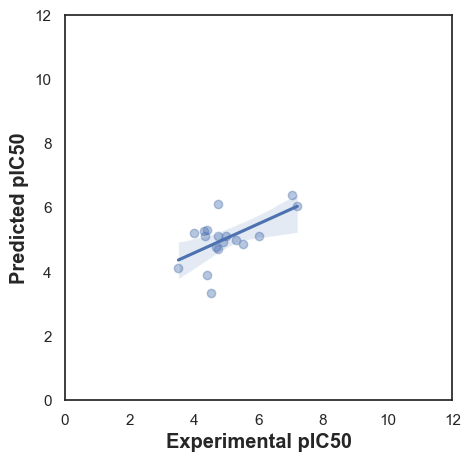

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=Y_test, y=Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show()